# Quantum annealing

On a real quantum annealing device, we drop the stringent theoretical requirements of following the adiabatic pathway and we repeat the transition over and over again. Then we choose the lowest energy solution as our optimum.

The classical 'simulator' for a quantum annealer is some heuristic solver of combinatorial optimization, for instance, simulated annealing. We use the dimod package to implement the Hamiltonian with a small gap: $H_1=-1000\sigma^Z_1\sigma^Z_2-0.01\sigma^Z_2\sigma^Z_3-50\sigma^Z_1-.5\sigma^Z_3$.

Here gap could be defined as the energy difference between ground state and first excited state energy levels.

In [22]:
import numpy as np
import dimod
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
import minorminer
%matplotlib inline

In [16]:
J = {(0, 1): 1000.0, (1, 2): 0.01}
h = {0:-50, 1:0, 2:.5}
model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)

In [17]:
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=10)
print(response)

   0  1  2   energy num_oc.
2 +1 -1 -1 -1050.49       1
3 +1 -1 -1 -1050.49       1
4 +1 -1 -1 -1050.49       1
5 +1 -1 -1 -1050.49       1
0 -1 +1 -1  -950.51       1
1 -1 +1 -1  -950.51       1
6 -1 +1 -1  -950.51       1
7 -1 +1 -1  -950.51       1
8 -1 +1 -1  -950.51       1
9 -1 +1 -1  -950.51       1
['SPIN', 10 rows, 10 samples, 3 variables]


In [18]:
print([solution.energy for solution in response.data()])

[-1050.49, -1050.49, -1050.49, -1050.49, -950.51, -950.51, -950.51, -950.51, -950.51, -950.51]


Unlike in the case of a simple adiabatic quantum system, you often do not got the ground state. Hence, it could be said that the problem of finding a GSE level is also hard for a classical heuristic solver, which should not come as a surprise.

The qubits are often not fully connected, especially not in superconducting architectures. This is why we have to embed our graph in the connectivity graph of the hardware. In the case of the D-Wave 2048Q system, the connectivity has the Chimera graph structure and we are interested in the chain length of an embedding, which reflects how many physical qubits are used to represent a logical qubit. Assume that your quantum device has a Chimera structure of four unit cells, that is, 8 times 4 = 32 qubits.

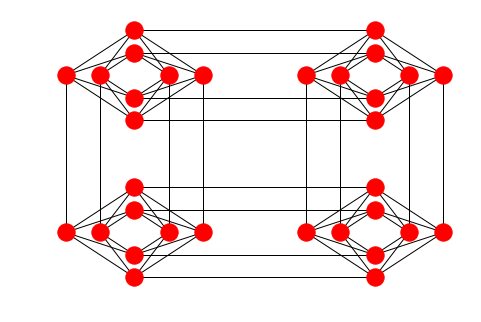

In [19]:
connectivity_structure = dnx.chimera_graph(2, 2)
dnx.draw_chimera(connectivity_structure)
plt.show()

Let's try to embed the complete graph $K_n$ on eight nodes:

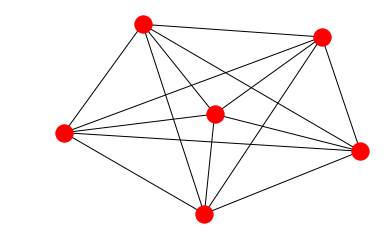

In [38]:
G = nx.complete_graph(6)
plt.axis('off') 
nx.draw_networkx(G, with_labels=False)

The function `find_embedding` of the package minorminer returns you a dictionary: the keys represent the nodes of the graph to be embedded, and the values are a list (the chain) of physical qubits for that particular graph node. We can then use this to find maximum chain length.

In [39]:
def get_max_chain_length(embedded_graph):
    dnx.draw_chimera_embedding(connectivity_structure, embedded_graph)
    plt.show()
    max_chain_length = 0
    for _, chain in embedded_graph.items():
        if len(chain) > max_chain_length:
            max_chain_length = len(chain)
    return max_chain_length

Now, finding the optimal embedding is NP-hard, so the minorminer package implements a heuristic algorithm that relies on randomness. It often occurs that subsequent runs yield different chain lengths. Running the `find_embedding` function to embed the graph `G` in the graph `connectivity_structure` N times gives us the embedding with the shortest maximum chain length, and the longest maximum chain length.

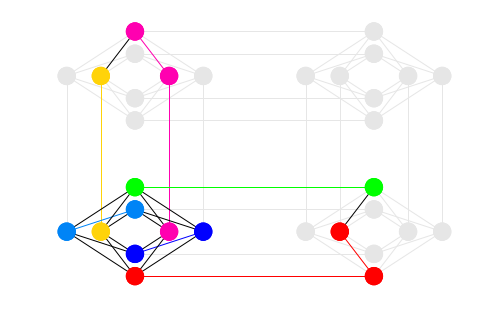

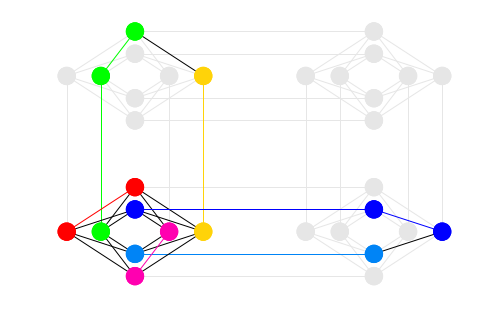

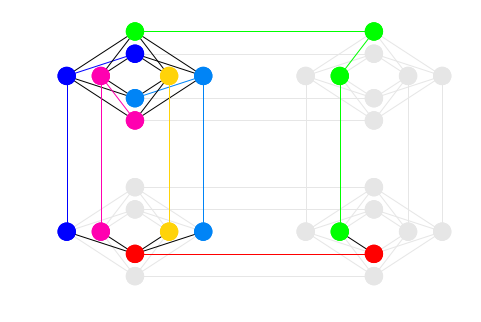

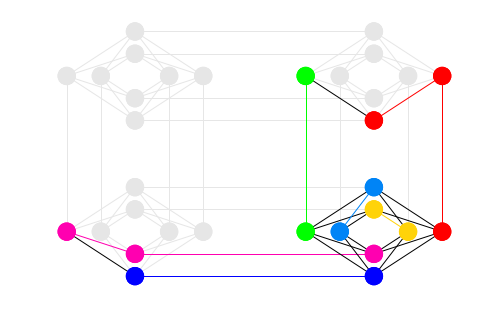

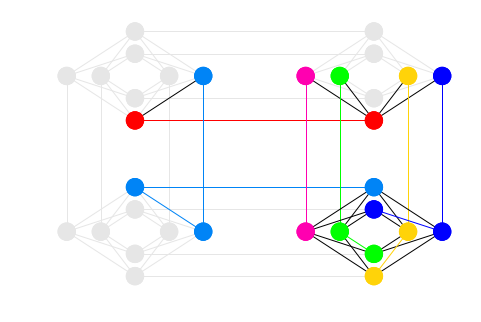

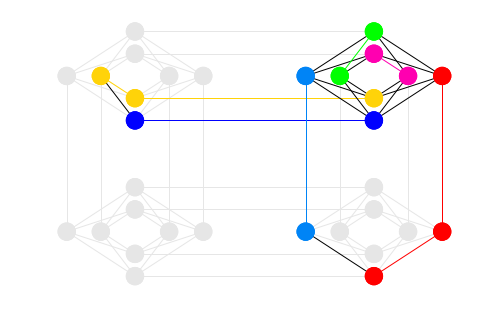

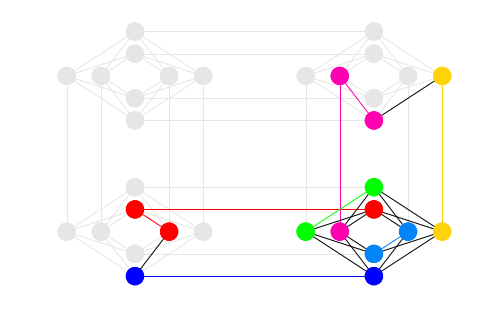

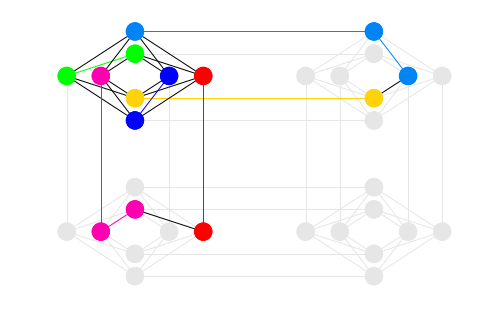

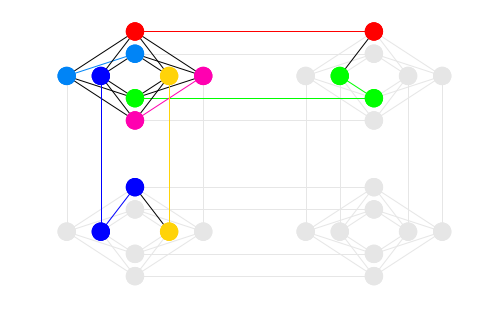

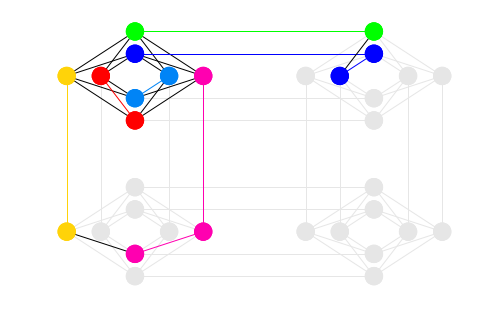

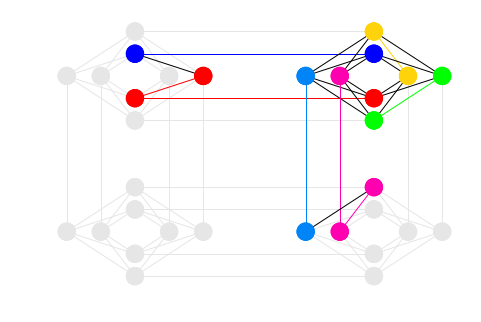

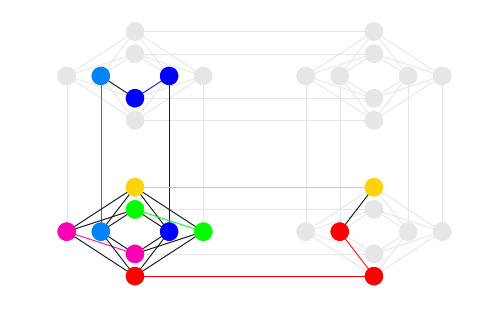

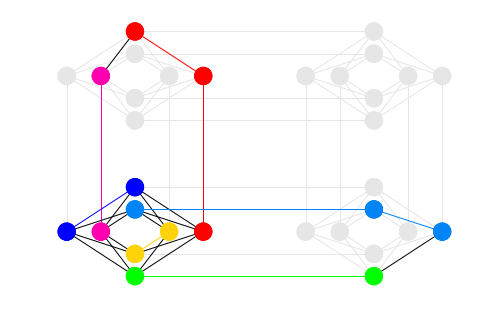

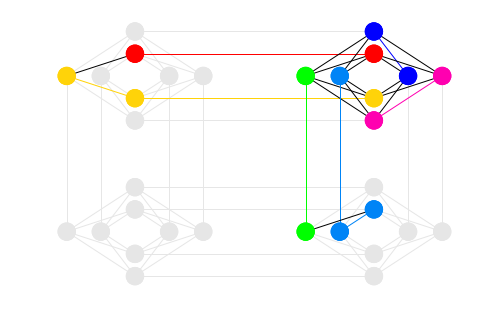

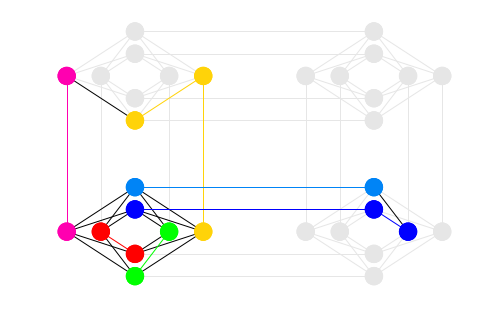

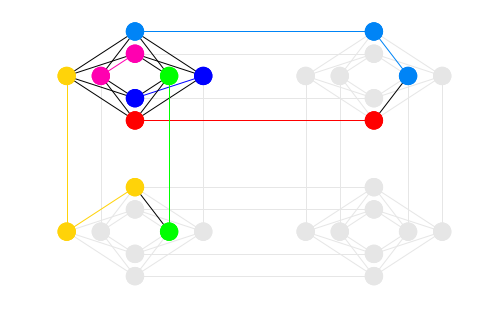

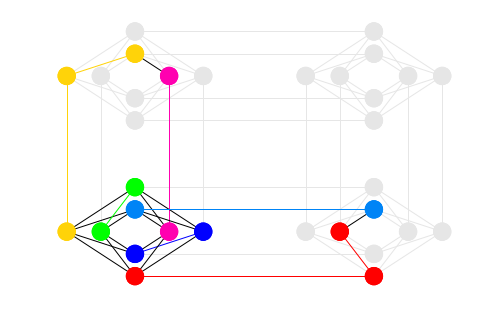

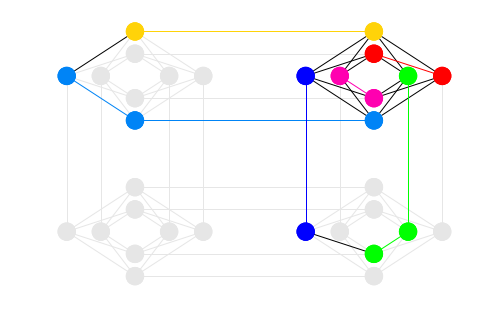

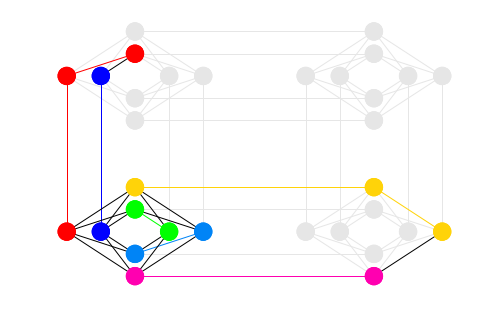

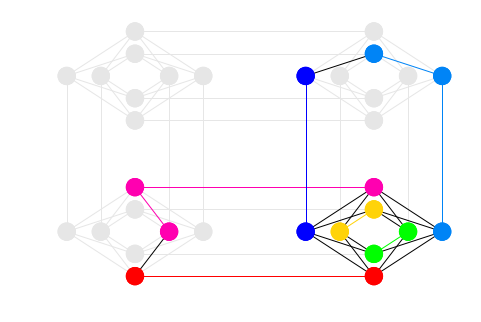

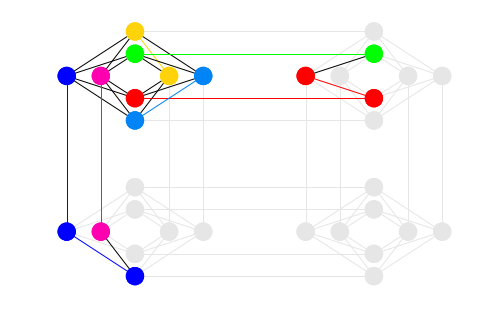

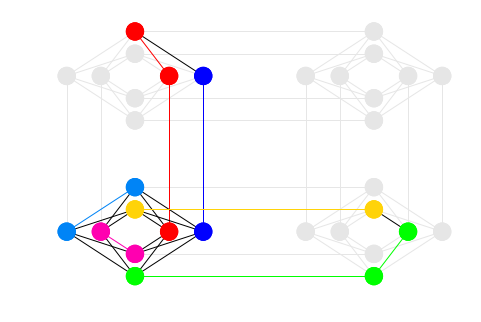

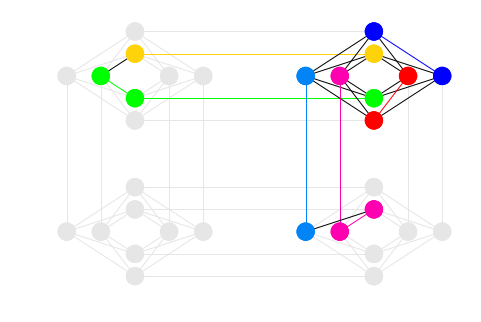

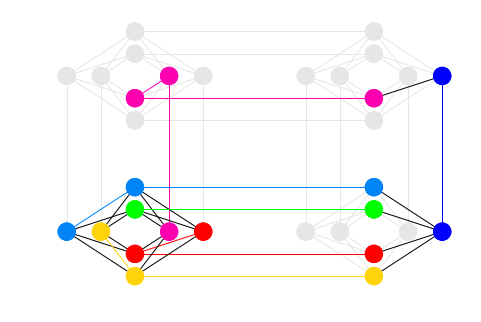

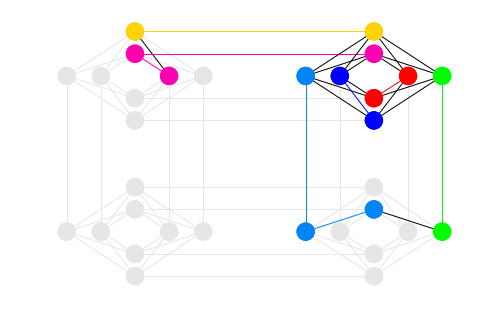

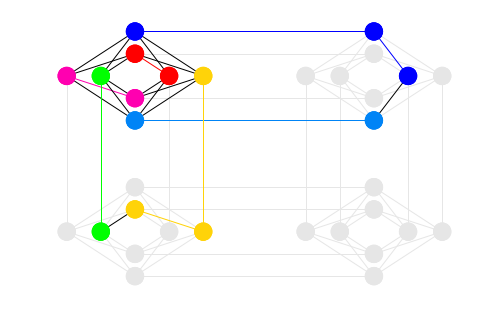

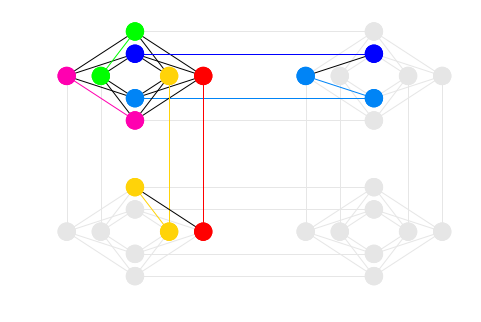

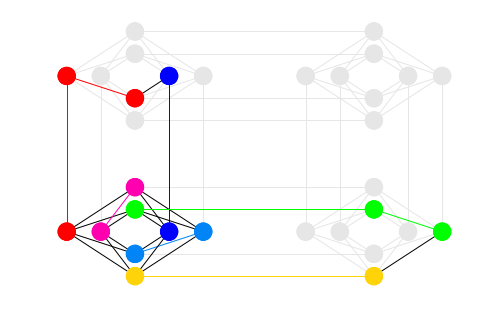

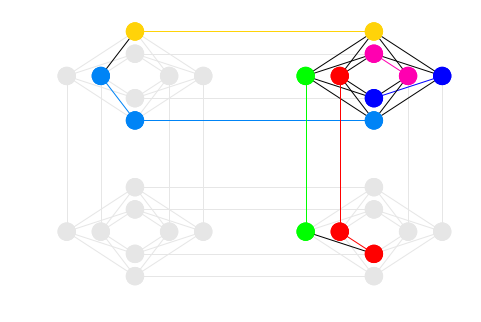

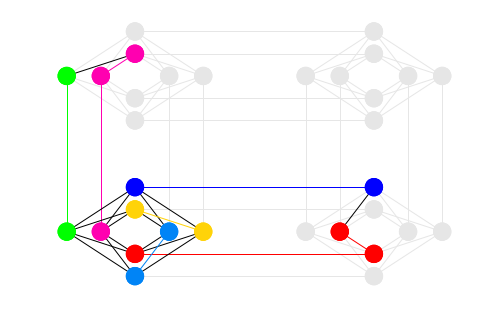

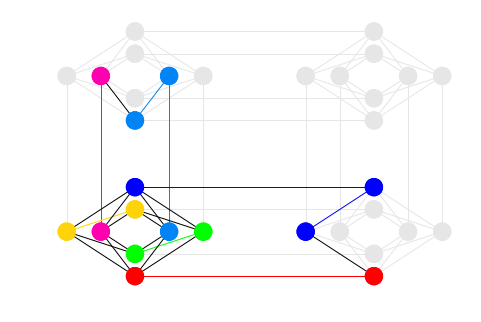

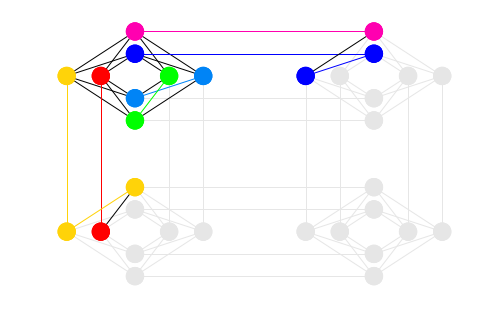

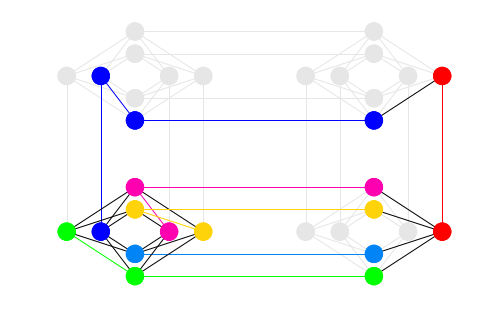

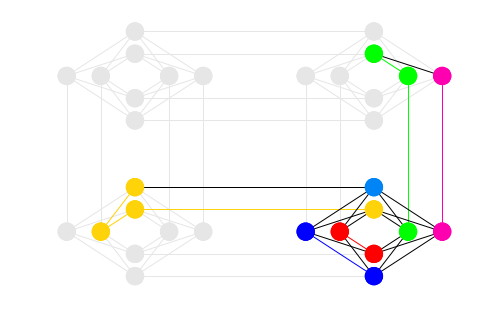

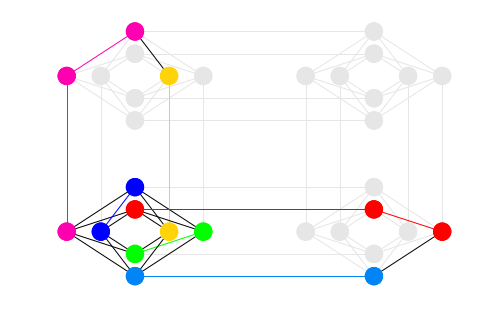

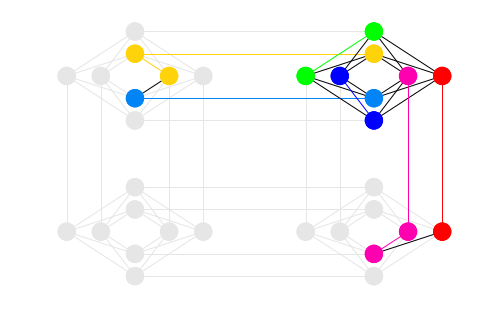

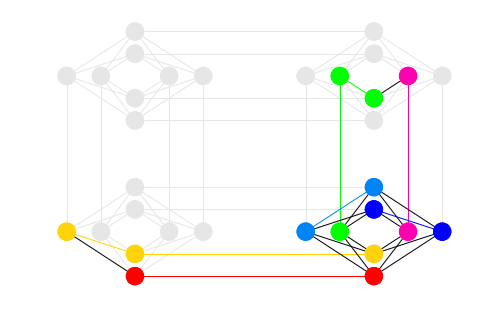

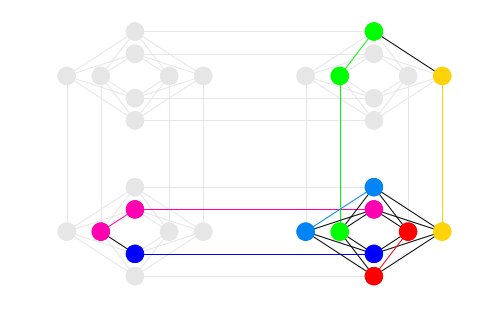

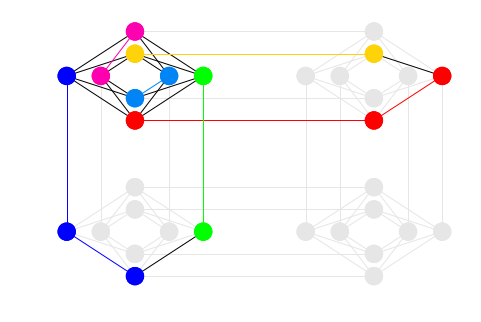

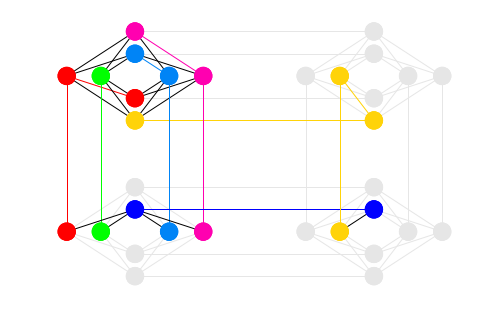

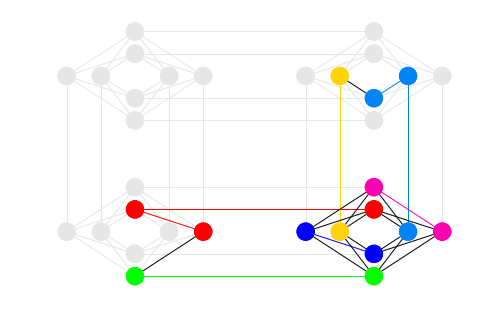

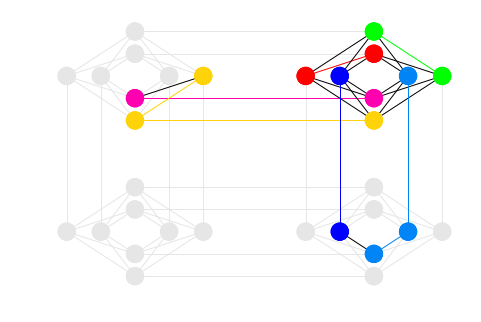

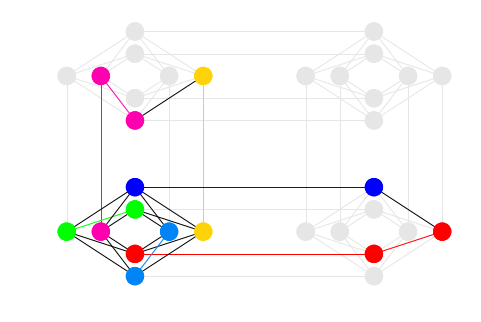

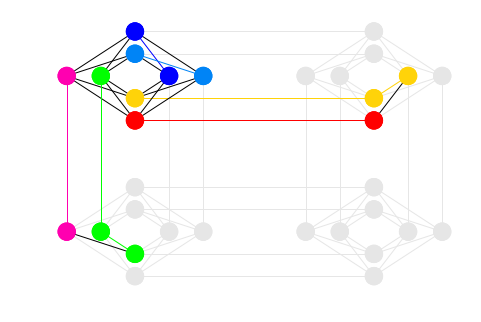

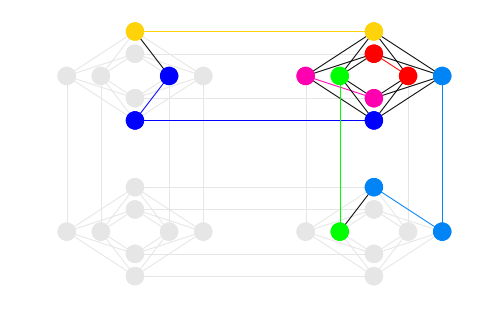

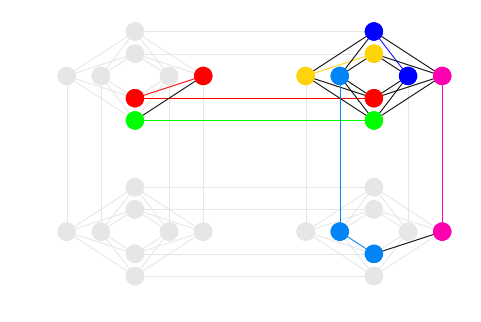

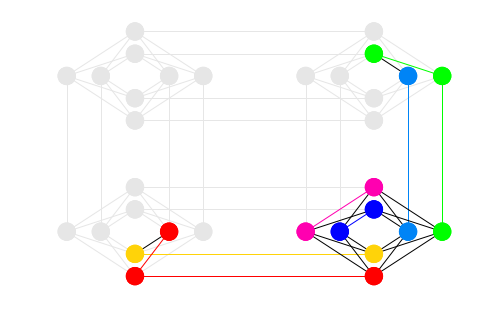

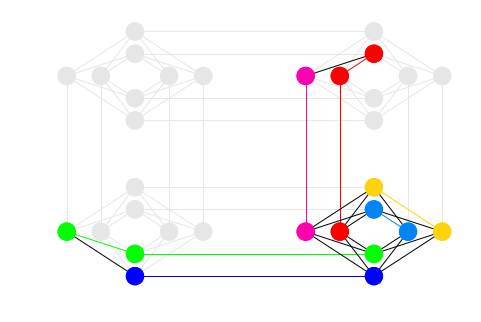

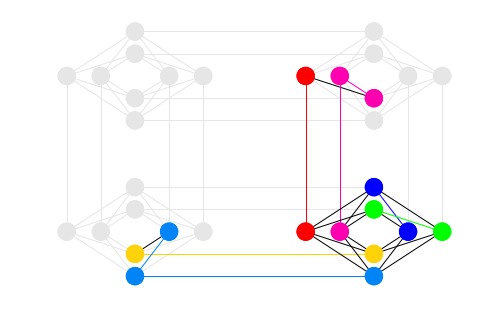

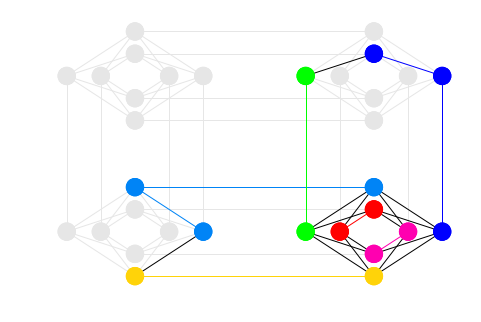

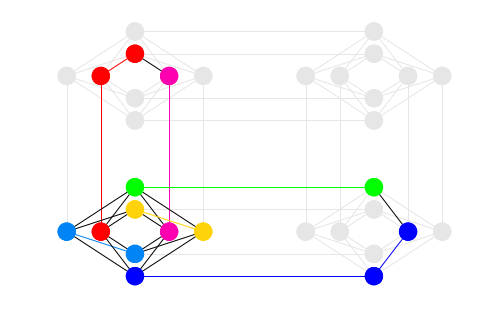

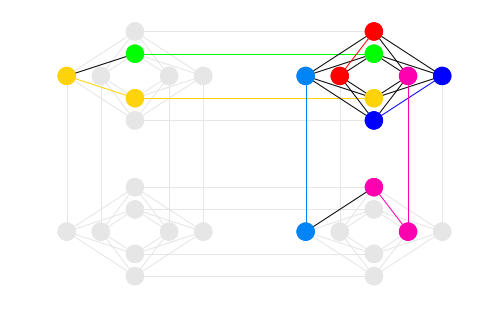

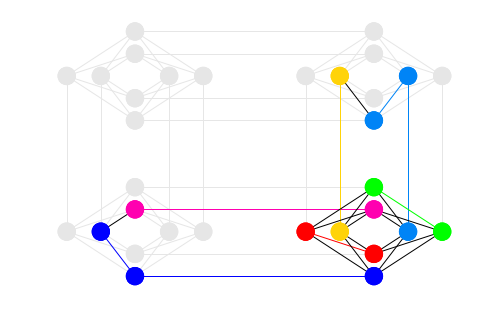

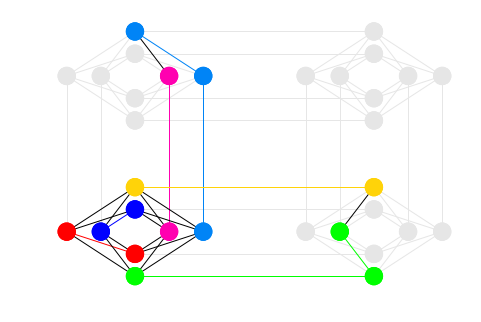

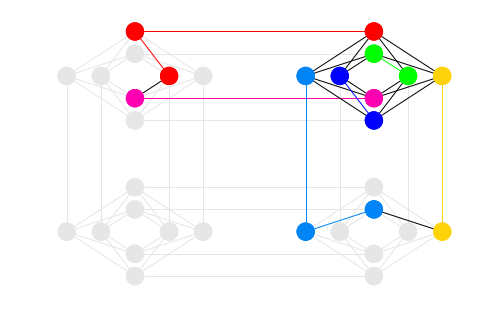

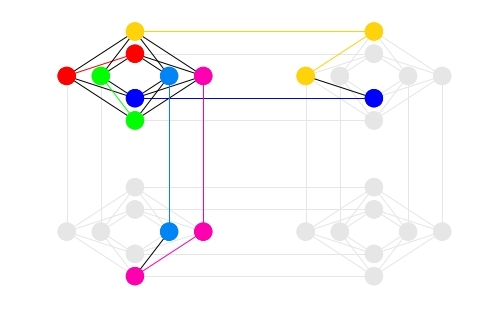

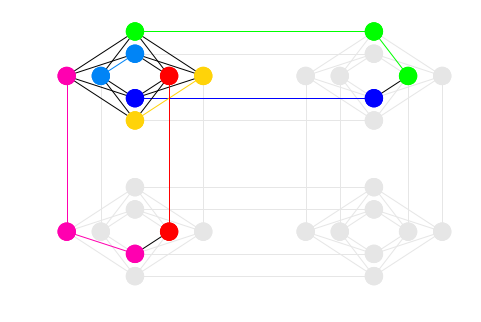

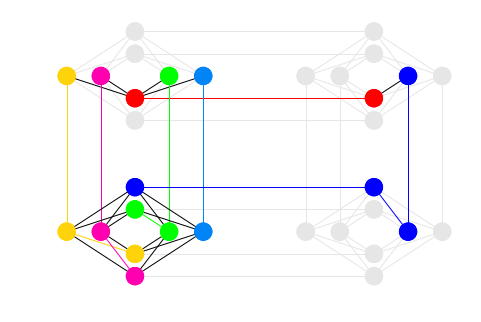

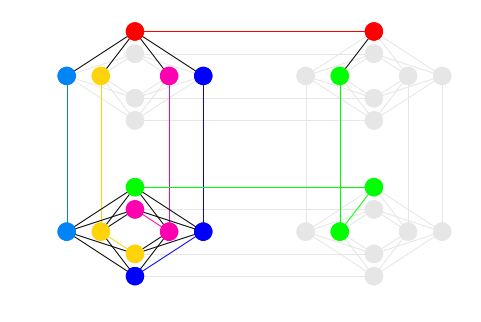

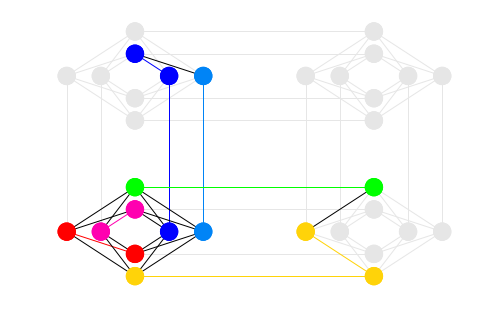

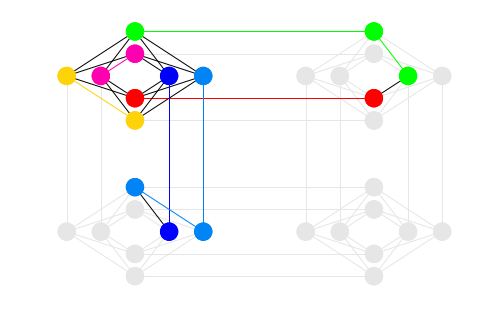

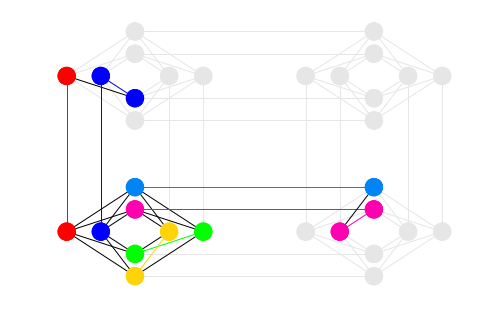

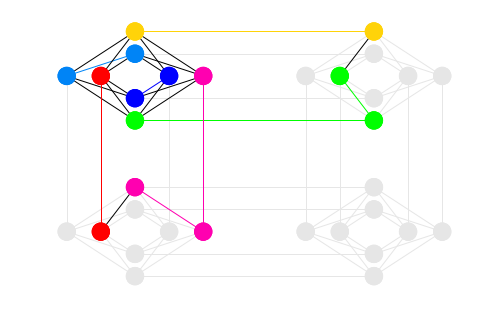

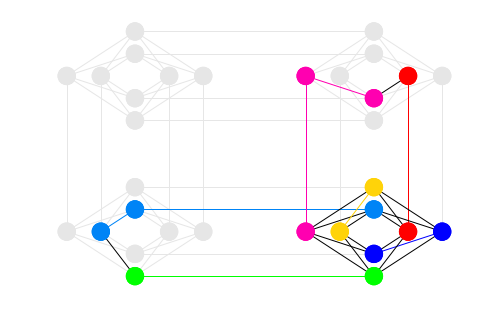

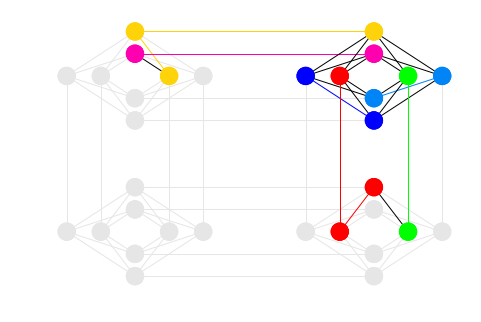

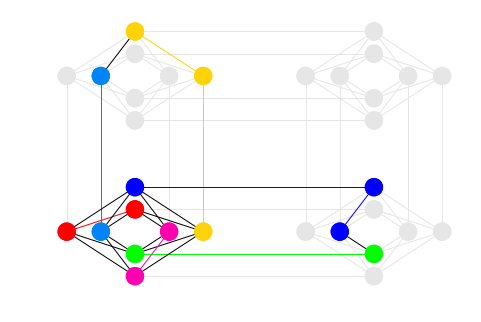

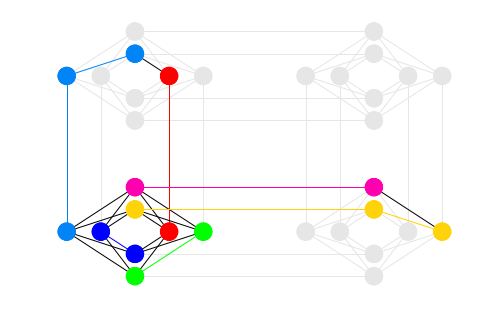

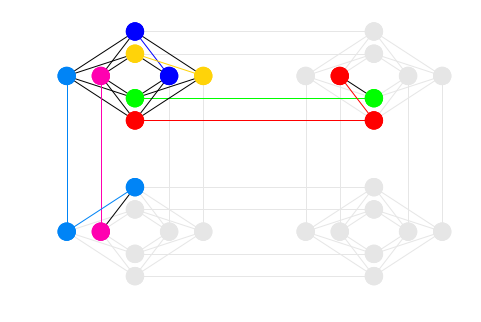

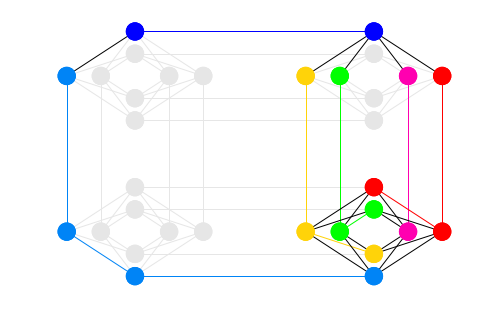

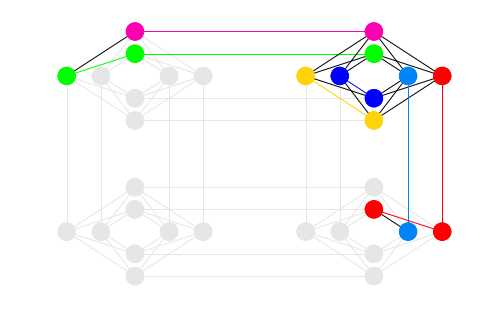

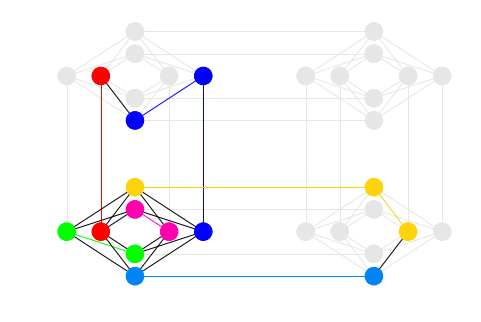

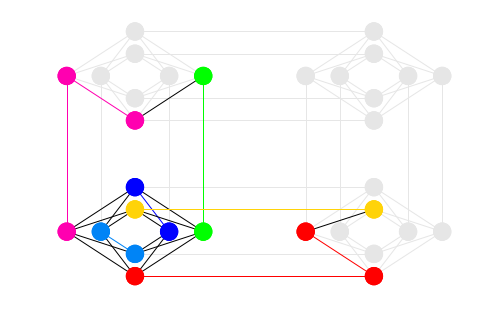

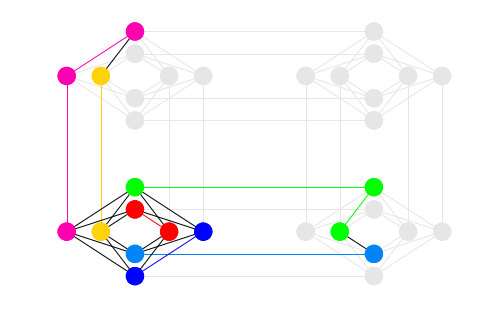

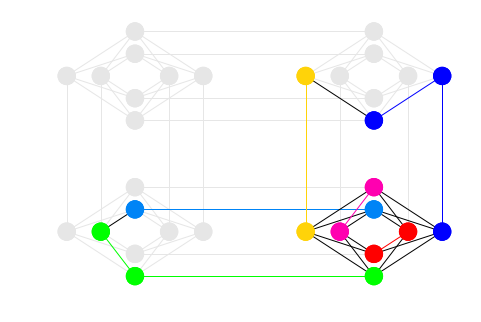

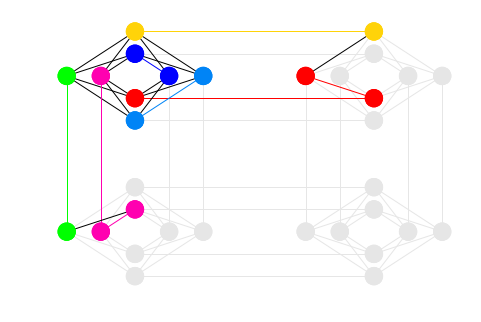

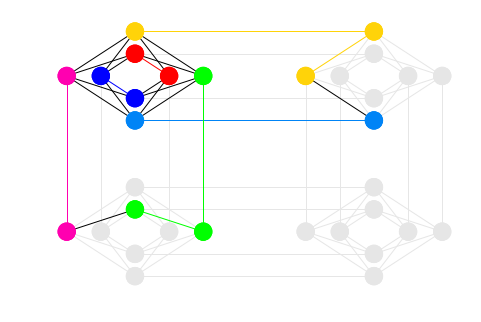

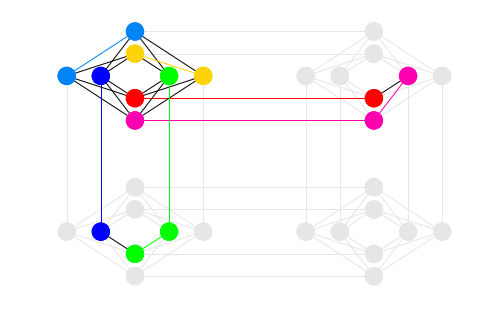

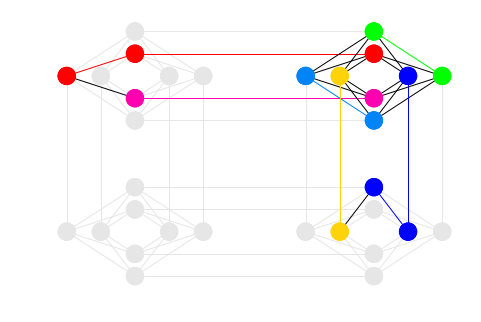

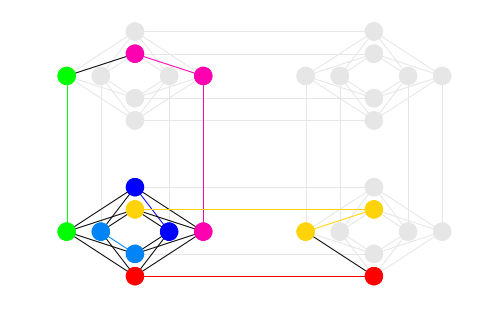

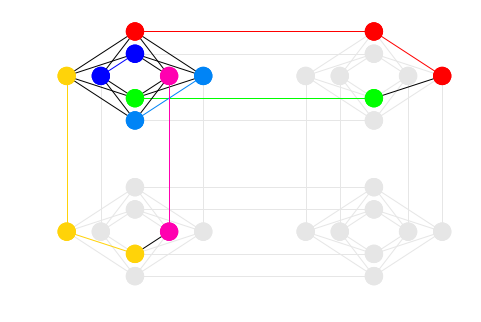

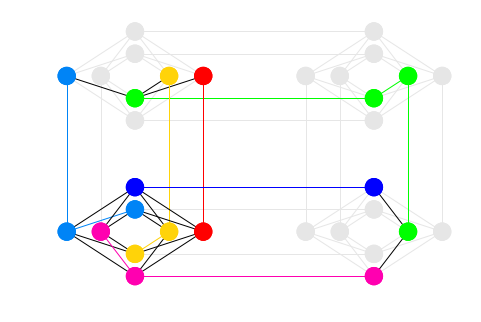

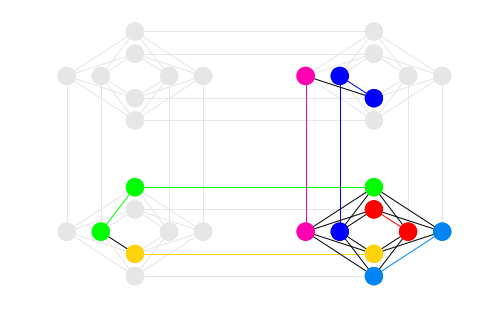

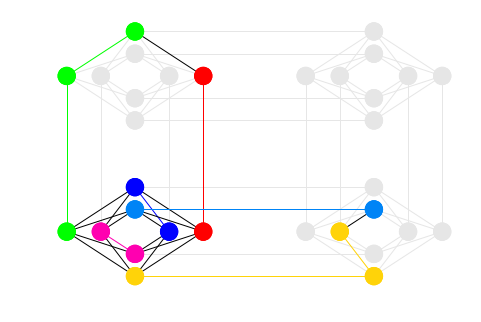

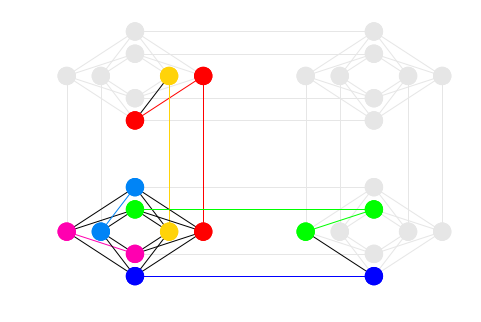

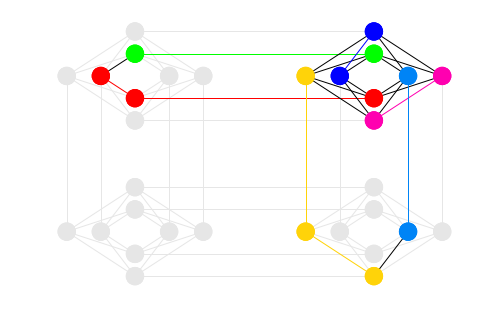

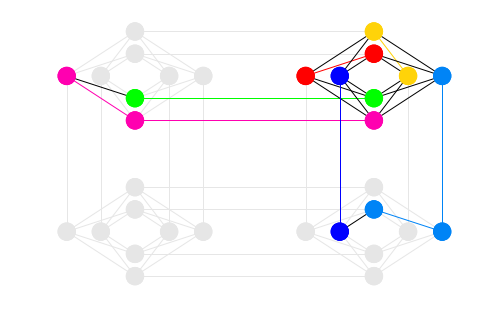

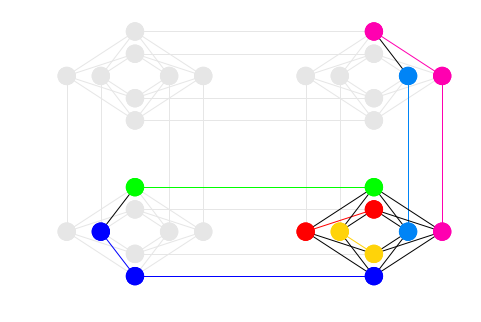

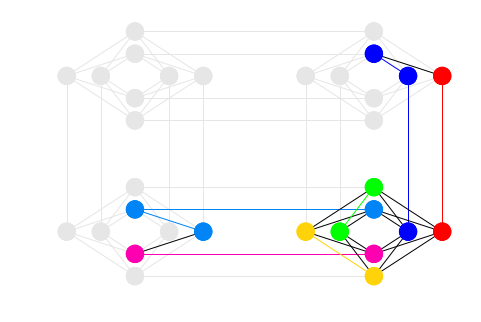

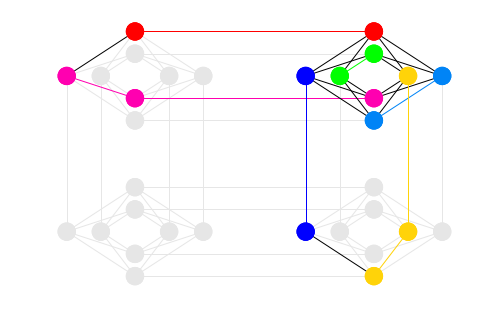

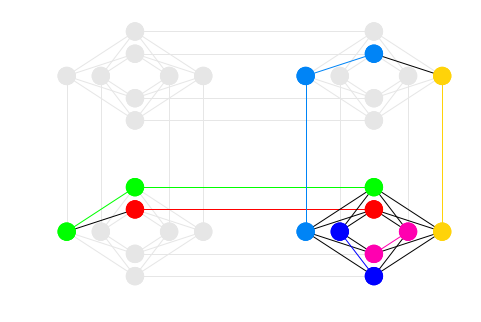

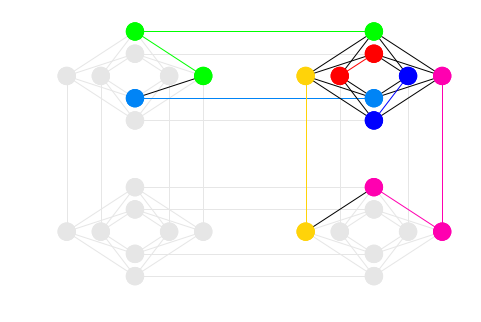

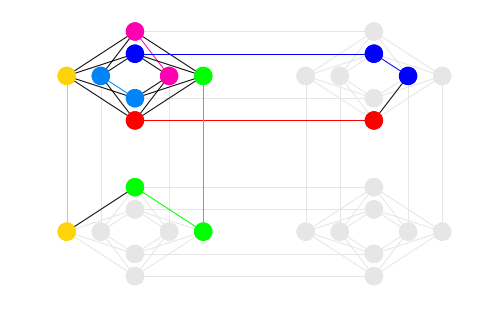

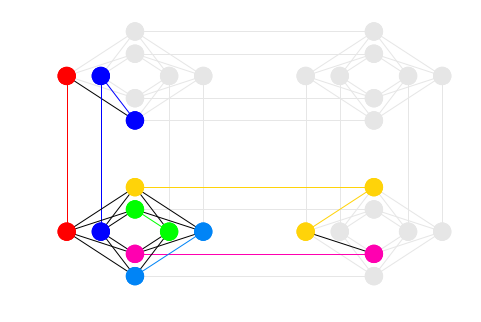

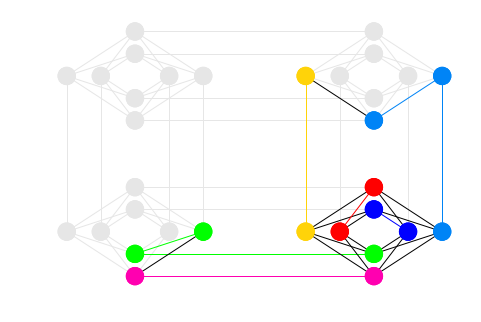

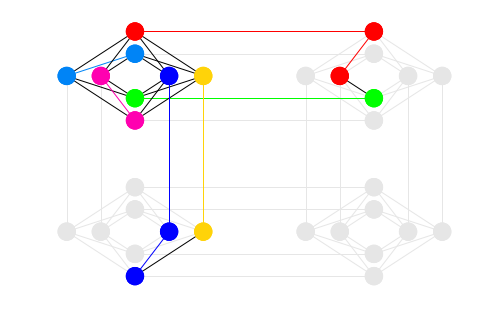

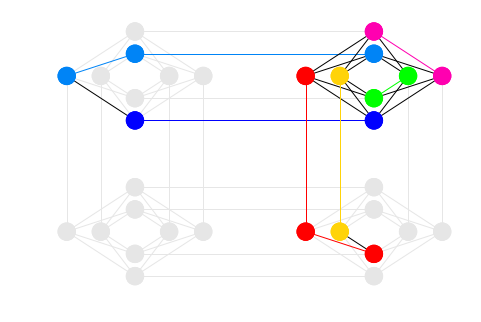

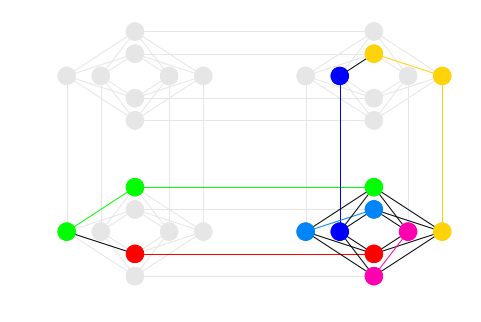

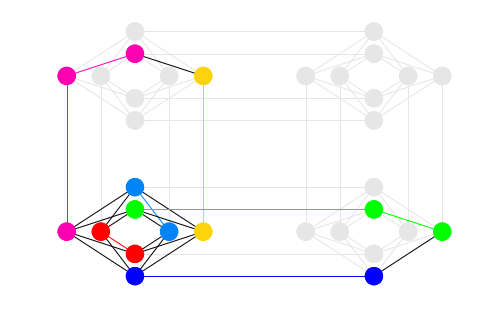

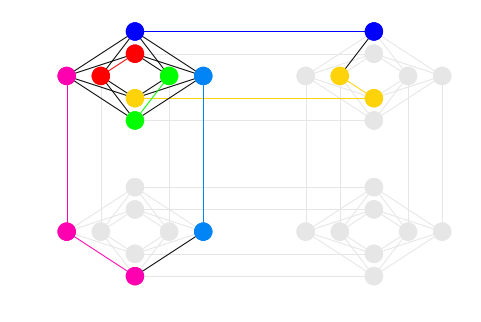

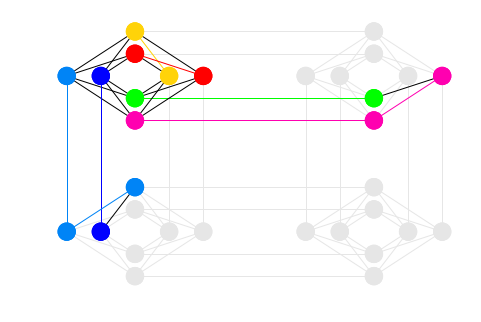

In [40]:
N=100
shortest_chains = N
longest_chains = 0
shortest_chain = {}
longest_chain = {}
for i in range(N):
    embedded_graph = minorminer.find_embedding(G.edges(), connectivity_structure.edges())
    lent = get_max_chain_length(embedded_graph)
    if lent < shortest_chains:
        shortest_chains = lent
        shortest_chain = embedded_graph
    if lent > longest_chains:
        longest_chains = lent
        longest_chain = embedded_graph

Let's plot the embeddings:

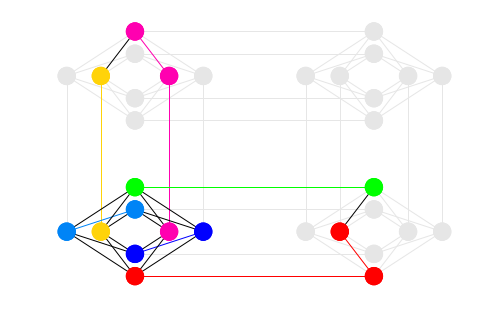

In [41]:
dnx.draw_chimera_embedding(connectivity_structure, shortest_chain)
plt.show()

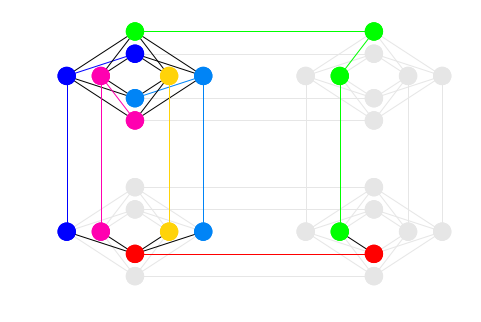

In [42]:
dnx.draw_chimera_embedding(connectivity_structure, longest_chain)
plt.show()

Depending on the heuristic outcome, you have a chance of seeing that the embedding with the longer chains uses more unit cells. Since the optimality of an embedding is hard to guarantee, if we want to use quantum annealing for machine learning, we should think of models that are either easy to embed or for which we can manually construct the optimal embedding.